<a href="https://colab.research.google.com/github/lhmin0614/Randomly_Wired_NN/blob/main/comparison_models1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing and Load Dataset

In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.5.0


In [ ]:
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


In [ ]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()


170500096/170498071 [==============================] - 21s 0us/step


In [ ]:
print(len(training_images), len(validation_images))

50000 10000


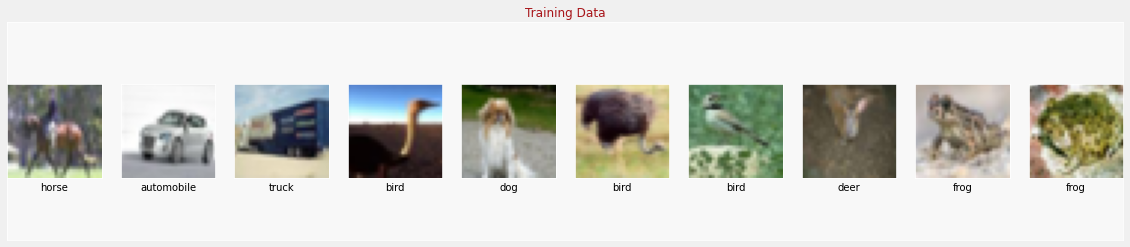

In [ ]:
display_images(training_images, training_labels, training_labels, "Training Data" )

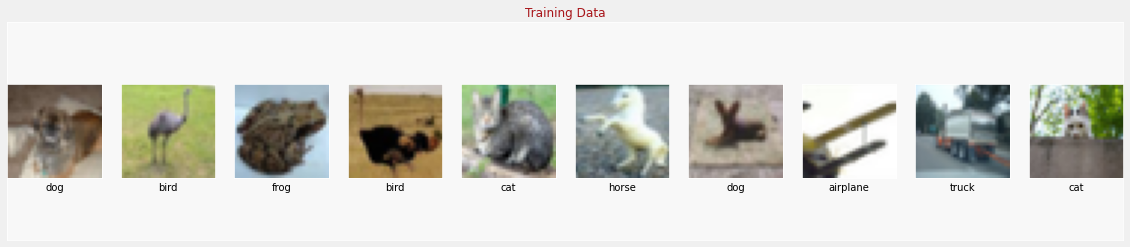

In [ ]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

In [ ]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

## MobileNet

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor =tf.keras.applications.MobileNet(input_shape=( 96, 96, 3 ),
                                               include_top=False,
                                               weights=None)(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(3, 3))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenet_1.00_96 (Functiona (None, 3, 3, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800

In [ ]:
EPOCHS = 50
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/50
782/782 [==============================] - 89s 71ms/step - loss: 1.8665 - accuracy: 0.2828 - val_loss: 2.0491 - val_accuracy: 0.2634
Epoch 2/50
782/782 [==============================] - 55s 70ms/step - loss: 1.5383 - accuracy: 0.4195 - val_loss: 1.5142 - val_accuracy: 0.4468
Epoch 3/50
782/782 [==============================] - 55s 70ms/step - loss: 1.3753 - accuracy: 0.4961 - val_loss: 1.7822 - val_accuracy: 0.4134
Epoch 4/50
782/782 [==============================] - 55s 70ms/step - loss: 1.2458 - accuracy: 0.5504 - val_loss: 1.4732 - val_accuracy: 0.4876
Epoch 5/50
782/782 [==============================] - 55s 70ms/step - loss: 1.1250 - accuracy: 0.5957 - val_loss: 1.2514 - val_accuracy: 0.5605
Epoch 6/50
782/782 [==============================] - 55s 70ms/step - loss: 1.0258 - accuracy: 0.6314 - val_loss: 1.1313 - val_accuracy: 0.6016
Epoch 7/50
782/782 [==============================] - 55s 70ms/step - loss: 0.9411 - accuracy: 0.6642 - val_loss: 1.0793 - val_accuracy:

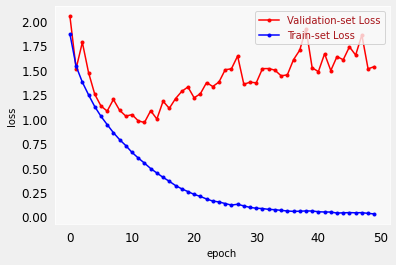

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 2s 14ms/step - loss: 1.5339 - accuracy: 0.7394


##VGG19

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.VGG19(input_shape=(96, 96, 3),
                                               include_top=False,
                                               weights=None)(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(3, 3))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 96, 96, 3)         0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               5248

In [ ]:
EPOCHS = 50
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/50
782/782 [==============================] - 158s 196ms/step - loss: 2.0577 - accuracy: 0.2381 - val_loss: 1.8458 - val_accuracy: 0.3294
Epoch 2/50
782/782 [==============================] - 152s 195ms/step - loss: 1.8094 - accuracy: 0.3423 - val_loss: 1.8613 - val_accuracy: 0.3176
Epoch 3/50
782/782 [==============================] - 152s 195ms/step - loss: 1.6286 - accuracy: 0.4131 - val_loss: 1.5818 - val_accuracy: 0.4210
Epoch 4/50
782/782 [==============================] - 153s 195ms/step - loss: 1.4744 - accuracy: 0.4715 - val_loss: 1.7399 - val_accuracy: 0.3823
Epoch 5/50
782/782 [==============================] - 153s 195ms/step - loss: 1.3358 - accuracy: 0.5236 - val_loss: 1.4970 - val_accuracy: 0.4596
Epoch 6/50
782/782 [==============================] - 153s 196ms/step - loss: 1.2140 - accuracy: 0.5700 - val_loss: 1.5901 - val_accuracy: 0.4841
Epoch 7/50
782/782 [==============================] - 153s 195ms/step - loss: 1.1107 - accuracy: 0.6105 - val_loss: 1.2460 -

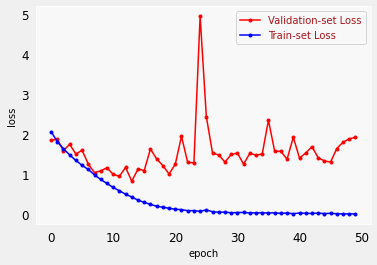

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 9s 56ms/step - loss: 1.9161 - accuracy: 0.7885


##NasNetMobile

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.NASNetMobile(input_shape=(96, 96, 3),
                                               include_top=False,
                                               weights=None)(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(3, 3))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 96, 96, 3)         0         
_________________________________________________________________
NASNet (Functional)          (None, 3, 3, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1056)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1056)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1082368   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               5248

In [ ]:
EPOCHS = 50
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/50
782/782 [==============================] - 169s 156ms/step - loss: 1.7465 - accuracy: 0.3526 - val_loss: 2.7876 - val_accuracy: 0.0847
Epoch 2/50
782/782 [==============================] - 122s 156ms/step - loss: 1.4170 - accuracy: 0.4812 - val_loss: 2.3352 - val_accuracy: 0.1280
Epoch 3/50
782/782 [==============================] - 122s 157ms/step - loss: 1.2635 - accuracy: 0.5428 - val_loss: 2.3351 - val_accuracy: 0.1331
Epoch 4/50
782/782 [==============================] - 122s 156ms/step - loss: 1.1398 - accuracy: 0.5939 - val_loss: 2.4421 - val_accuracy: 0.0969
Epoch 5/50
782/782 [==============================] - 122s 156ms/step - loss: 1.0415 - accuracy: 0.6270 - val_loss: 2.5399 - val_accuracy: 0.0949
Epoch 6/50
782/782 [==============================] - 122s 156ms/step - loss: 0.9552 - accuracy: 0.6586 - val_loss: 2.5692 - val_accuracy: 0.0994
Epoch 7/50
782/782 [==============================] - 122s 156ms/step - loss: 0.8810 - accuracy: 0.6874 - val_loss: 2.7399 -

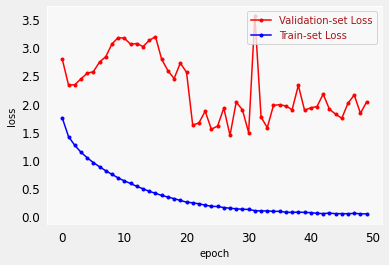

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 6s 36ms/step - loss: 2.0327 - accuracy: 0.6655


## MobileNetV2

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.MobileNetV2(input_shape=(96, 96, 3),
                                               include_top=False,
                                               weights=None)(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(3, 3))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800

In [ ]:
EPOCHS = 50
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/50
782/782 [==============================] - 96s 78ms/step - loss: 1.7927 - accuracy: 0.3170 - val_loss: 2.3131 - val_accuracy: 0.1000
Epoch 2/50
782/782 [==============================] - 60s 76ms/step - loss: 1.4292 - accuracy: 0.4726 - val_loss: 2.3614 - val_accuracy: 0.1000
Epoch 3/50
782/782 [==============================] - 61s 77ms/step - loss: 1.2289 - accuracy: 0.5543 - val_loss: 2.4308 - val_accuracy: 0.1000
Epoch 4/50
782/782 [==============================] - 61s 78ms/step - loss: 1.0800 - accuracy: 0.6113 - val_loss: 2.5231 - val_accuracy: 0.1000
Epoch 5/50
782/782 [==============================] - 61s 78ms/step - loss: 0.9601 - accuracy: 0.6562 - val_loss: 2.7056 - val_accuracy: 0.1000
Epoch 6/50
782/782 [==============================] - 61s 78ms/step - loss: 0.8650 - accuracy: 0.6915 - val_loss: 2.8303 - val_accuracy: 0.1000
Epoch 7/50
782/782 [==============================] - 61s 78ms/step - loss: 0.7794 - accuracy: 0.7212 - val_loss: 2.9170 - val_accuracy:

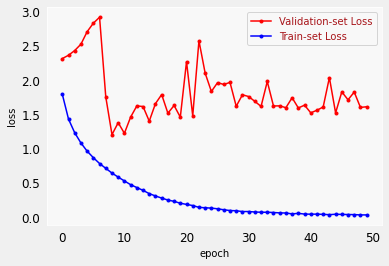

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 3s 17ms/step - loss: 1.6090 - accuracy: 0.7456


## MobileNetV3Small

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.MobileNetV3Small(input_shape=(96, 96, 3),
                                               include_top=False,
                                               weights=None)(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(3, 3))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 96, 96, 3)         0         
_________________________________________________________________
MobilenetV3small (Functional (None, 3, 3, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800

In [ ]:
EPOCHS = 50
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/50
782/782 [==============================] - 95s 77ms/step - loss: 1.8958 - accuracy: 0.2819 - val_loss: 2.3152 - val_accuracy: 0.1000
Epoch 2/50
782/782 [==============================] - 59s 75ms/step - loss: 1.3980 - accuracy: 0.4841 - val_loss: 2.3277 - val_accuracy: 0.1000
Epoch 3/50
782/782 [==============================] - 59s 76ms/step - loss: 1.1951 - accuracy: 0.5700 - val_loss: 2.3452 - val_accuracy: 0.1000
Epoch 4/50
782/782 [==============================] - 59s 76ms/step - loss: 1.0610 - accuracy: 0.6227 - val_loss: 2.4009 - val_accuracy: 0.1000
Epoch 5/50
782/782 [==============================] - 59s 76ms/step - loss: 0.9530 - accuracy: 0.6618 - val_loss: 2.4947 - val_accuracy: 0.1000
Epoch 6/50
782/782 [==============================] - 59s 75ms/step - loss: 0.8702 - accuracy: 0.6916 - val_loss: 2.5116 - val_accuracy: 0.1002
Epoch 7/50
782/782 [==============================] - 59s 75ms/step - loss: 0.8041 - accuracy: 0.7153 - val_loss: 2.0101 - val_accuracy:

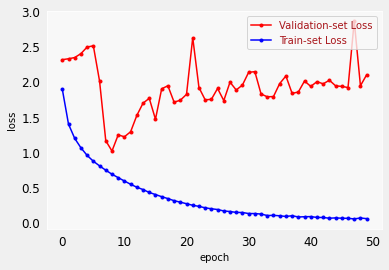

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 3s 21ms/step - loss: 2.0998 - accuracy: 0.6652


## MobileNetV3Large

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.MobileNetV3Large(input_shape=(96, 96, 3),
                                               include_top=False,
                                               weights=None)(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(3, 3))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 96, 96, 3)         0         
_________________________________________________________________
MobilenetV3large (Functional (None, 3, 3, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               5248

In [ ]:
EPOCHS = 50
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/50
782/782 [==============================] - 127s 154ms/step - loss: 1.8161 - accuracy: 0.3078 - val_loss: 2.3094 - val_accuracy: 0.1000
Epoch 2/50
782/782 [==============================] - 118s 151ms/step - loss: 1.3930 - accuracy: 0.4844 - val_loss: 2.3182 - val_accuracy: 0.1000
Epoch 3/50
782/782 [==============================] - 118s 151ms/step - loss: 1.1819 - accuracy: 0.5704 - val_loss: 2.3371 - val_accuracy: 0.1000
Epoch 4/50
782/782 [==============================] - 118s 151ms/step - loss: 1.0239 - accuracy: 0.6319 - val_loss: 2.3869 - val_accuracy: 0.1000
Epoch 5/50
782/782 [==============================] - 118s 151ms/step - loss: 0.9008 - accuracy: 0.6785 - val_loss: 2.4753 - val_accuracy: 0.1000
Epoch 6/50
782/782 [==============================] - 123s 157ms/step - loss: 0.8017 - accuracy: 0.7155 - val_loss: 2.5392 - val_accuracy: 0.1069
Epoch 7/50
782/782 [==============================] - 118s 151ms/step - loss: 0.7206 - accuracy: 0.7449 - val_loss: 2.4493 -

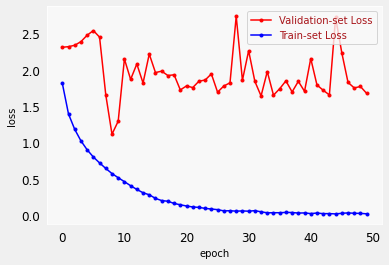

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 6s 39ms/step - loss: 1.6761 - accuracy: 0.7414


## ResNet50

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.ResNet50(input_shape=(96, 96, 3),
                                               include_top=False,
                                               weights=None)(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(3, 3))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 96, 96, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               5248

In [ ]:
EPOCHS = 50
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/50
782/782 [==============================] - 257s 320ms/step - loss: 1.8398 - accuracy: 0.3154 - val_loss: 1.9676 - val_accuracy: 0.3333
Epoch 2/50
782/782 [==============================] - 249s 319ms/step - loss: 1.4431 - accuracy: 0.4717 - val_loss: 1.6159 - val_accuracy: 0.4197
Epoch 3/50
782/782 [==============================] - 250s 319ms/step - loss: 1.2623 - accuracy: 0.5417 - val_loss: 1.3206 - val_accuracy: 0.5178
Epoch 4/50
782/782 [==============================] - 249s 319ms/step - loss: 1.1259 - accuracy: 0.5967 - val_loss: 1.1567 - val_accuracy: 0.5845
Epoch 5/50
782/782 [==============================] - 249s 319ms/step - loss: 0.9952 - accuracy: 0.6424 - val_loss: 1.4855 - val_accuracy: 0.5311
Epoch 6/50
782/782 [==============================] - 249s 319ms/step - loss: 0.8757 - accuracy: 0.6899 - val_loss: 1.4907 - val_accuracy: 0.5129
Epoch 7/50
782/782 [==============================] - 249s 319ms/step - loss: 0.7654 - accuracy: 0.7298 - val_loss: 1.2730 -

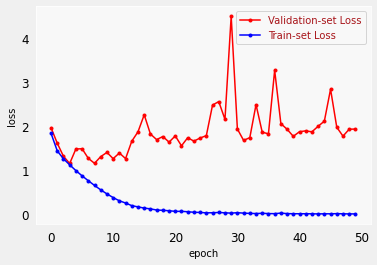

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 15s 92ms/step - loss: 1.9372 - accuracy: 0.7073


## ResNet101

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.ResNet101(input_shape=(96, 96, 3),
                                               include_top=False,
                                               weights=None)(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(3, 3))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 96, 96, 3)         0         
_________________________________________________________________
resnet101 (Functional)       (None, 3, 3, 2048)        42658176  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800

In [ ]:
EPOCHS = 50
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/50
782/782 [==============================] - 262s 285ms/step - loss: 1.9359 - accuracy: 0.2843 - val_loss: 1.8273 - val_accuracy: 0.3452
Epoch 2/50
782/782 [==============================] - 224s 287ms/step - loss: 1.5385 - accuracy: 0.4340 - val_loss: 1.6666 - val_accuracy: 0.3946
Epoch 3/50
782/782 [==============================] - 225s 287ms/step - loss: 1.3522 - accuracy: 0.5074 - val_loss: 1.3888 - val_accuracy: 0.5037
Epoch 4/50
782/782 [==============================] - 232s 297ms/step - loss: 1.2240 - accuracy: 0.5566 - val_loss: 1.3097 - val_accuracy: 0.5329
Epoch 5/50
782/782 [==============================] - 233s 298ms/step - loss: 1.1162 - accuracy: 0.5974 - val_loss: 1.4201 - val_accuracy: 0.5216
Epoch 6/50
782/782 [==============================] - 225s 287ms/step - loss: 1.0126 - accuracy: 0.6383 - val_loss: 1.3280 - val_accuracy: 0.5511
Epoch 7/50
782/782 [==============================] - 233s 297ms/step - loss: 0.9249 - accuracy: 0.6688 - val_loss: 1.1650 -

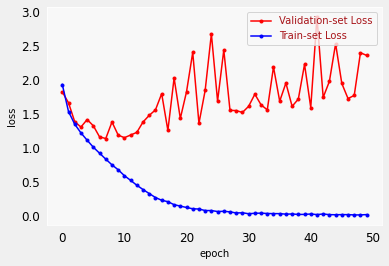

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 12s 78ms/step - loss: 2.3636 - accuracy: 0.6625


In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.NASNetLarge(input_shape=(96, 96, 3),
                                               include_top=False,
                                               weights=None)(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(3, 3))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 96, 96, 3)         0         
_________________________________________________________________
NASNet (Functional)          (None, 3, 3, 4032)        84916818  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 4032)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4032)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              4129792   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               5248

In [ ]:
EPOCHS = 50
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/50
782/782 [==============================] - 584s 718ms/step - loss: 1.6279 - accuracy: 0.3994 - val_loss: 3.5178 - val_accuracy: 0.0999
Epoch 2/50
782/782 [==============================] - 555s 709ms/step - loss: 1.3035 - accuracy: 0.5266 - val_loss: 2.3643 - val_accuracy: 0.1092
Epoch 3/50
782/782 [==============================] - 555s 710ms/step - loss: 1.1430 - accuracy: 0.5867 - val_loss: 2.4697 - val_accuracy: 0.1235
Epoch 4/50
782/782 [==============================] - 555s 710ms/step - loss: 1.0152 - accuracy: 0.6381 - val_loss: 2.5236 - val_accuracy: 0.1436
Epoch 5/50
782/782 [==============================] - 555s 710ms/step - loss: 0.9052 - accuracy: 0.6772 - val_loss: 2.5521 - val_accuracy: 0.1529
Epoch 6/50
782/782 [==============================] - 555s 710ms/step - loss: 0.8129 - accuracy: 0.7102 - val_loss: 2.6463 - val_accuracy: 0.1561
Epoch 7/50
782/782 [==============================] - 555s 710ms/step - loss: 0.7255 - accuracy: 0.7431 - val_loss: 2.5231 -

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

## VGG16

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.VGG16(input_shape=(96, 96, 3),
                                               include_top=False,
                                               weights=None)(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(3, 3))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 96, 96, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               5248

In [ ]:
EPOCHS = 50
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/50
782/782 [==============================] - 134s 166ms/step - loss: 1.9776 - accuracy: 0.2776 - val_loss: 2.4847 - val_accuracy: 0.2186
Epoch 2/50
782/782 [==============================] - 131s 167ms/step - loss: 1.6212 - accuracy: 0.4134 - val_loss: 1.5284 - val_accuracy: 0.4562
Epoch 3/50
782/782 [==============================] - 131s 168ms/step - loss: 1.4296 - accuracy: 0.4868 - val_loss: 2.1056 - val_accuracy: 0.3414
Epoch 4/50
782/782 [==============================] - 131s 167ms/step - loss: 1.2740 - accuracy: 0.5457 - val_loss: 1.4971 - val_accuracy: 0.4559
Epoch 5/50
782/782 [==============================] - 131s 168ms/step - loss: 1.1226 - accuracy: 0.6045 - val_loss: 1.3750 - val_accuracy: 0.4792
Epoch 6/50
782/782 [==============================] - 131s 168ms/step - loss: 0.9820 - accuracy: 0.6552 - val_loss: 1.2933 - val_accuracy: 0.5579
Epoch 7/50
782/782 [==============================] - 131s 168ms/step - loss: 0.8549 - accuracy: 0.7051 - val_loss: 1.5553 -

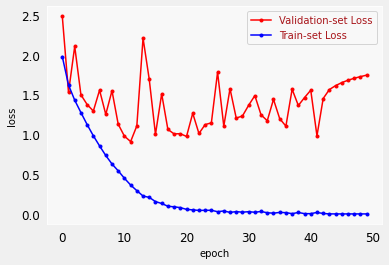

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 8s 49ms/step - loss: 1.7443 - accuracy: 0.8027


## Random wire neural net

In [ ]:
#imprt libraries
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def er_graph(n, p = 0.2):

  if p < math.log(n) / n:
      print("p is too small for given n.")
      # p> ln(n)/n이어야 single connected component graph가 될 확률이 높다.

  edges = list()
  # n by n random array
  # rand[i][j] == the probability of the edge(i,j) connected.
  rand = np.random.uniform(0.0, 1.0, size=(n, n))

  for i in range(n):
      for j in range(i+1, n):
          if rand[i][j] < p:
              edges.append((i, j)) 

  return edges

def ba_graph(n, m = 4):

  assert 1 <= m < n, "m must be smaller than n."

  edges = list()
  deg = np.zeros(n)

  for i in range(m, n):
      if i == m:
          for j in range(i):
              edges.append((j, i))
              deg[j] += 1
              deg[i] += 1
          continue

      connection = np.random.choice(range(n), size=m, replace=False, p=deg/np.sum(deg))
      for cnt in connection:
          edges.append((cnt, i))
          deg[cnt] += 1
          deg[i] += 1

  edges.sort()
  
  return edges
  
def ws_graph(n, k = 4, p = 0.75):
  
  if k % 2 != 0:                            # k should be even
    k = k - 1

  init_edges = [[] for i in range(n)]
  rand = np.random.uniform(0.0, 1.0, (n, k//2))
  edges = list()

  for i in range(n):                        # each node is connected to k neighbor nodes.
    for j in range(k//2):
      jj = (i + j + 1) % n
      init_edges[i].append(jj)
      init_edges[jj].append(i)

  for i in range(n):
    for j in range(k//2):
      jj = (i + j + 1) % n
      jjj = jj
      if rand[i][j] < p:
        rand_list = list(set(range(n)) - {i} - set(init_edges[i]))
        jjj = np.random.choice(rand_list, 1)[0]
        init_edges[i].append(jjj)
        init_edges[jjj].append(i)
        init_edges[i].remove(jj)
        init_edges[jj].remove(i)
      edges.append(tuple(sorted([i, jjj])))
  
  return sorted(edges)

In [ ]:
def in_out_nodes(n, edges):
  vertices = set(range(n))
  starts, ends = set(), set()

  for edge in edges:
    starts.add(edge[0])
    ends.add(edge[1])
  
  inputs = sorted(list(vertices - ends))
  outputs = sorted(list(vertices - starts))

  return inputs, outputs

def find_inputs(edges, i):
  i_inputs = []

  for edge in edges:
    if edge[1] == i:
      i_inputs.append(edge[0])
  
  return i_inputs

In [ ]:
class Weighted_Sum(layers.Layer):
  def __init__(self, n_inputs):
    super(Weighted_Sum, self).__init__()
    self.ws = [self.add_weight(shape=(1,), initializer=keras.initializers.GlorotNormal()
                               ,trainable=True) for j in range(n_inputs)]
  def call(self, inputs):
    return sum([inputs[j] * tf.nn.relu(self.ws[j]) for j in range(len(inputs))])

def network_generator(n, c, target_graph, inputs):
  input_nodes, output_nodes = in_out_nodes(n, target_graph)
  nodes = dict()

  for i in input_nodes:
    relu = layers.ReLU()
    sep_conv = layers.SeparableConv2D(c, 3, padding="same", strides=2)
    bn = layers.BatchNormalization()
    nodes[i] =bn(sep_conv(relu(inputs))) #ReLU - Conv - BN triplet
  
  for i in range(n):
    if i not in input_nodes:
      i_inputs = find_inputs(target_graph, i)
      weighted_sum = Weighted_Sum(len(i_inputs))
      nodes[i] = weighted_sum([nodes[j] for j in i_inputs])
      relu = layers.ReLU()
      sep_conv = layers.SeparableConv2D(c, 3, padding="same")
      bn = layers.BatchNormalization()
      nodes[i] = bn(sep_conv(relu(nodes[i])))
  
  if len(output_nodes) == 1:
    outputs = nodes[output_nodes[0]]
  else:
    outputs = layers.average([nodes[j] for j in output_nodes])
  
  return outputs

In [ ]:
def regular_regime(n, c, flag, img_shape, classes):

  assert(flag in ['er', 'ba', 'ws'])
  if flag == 'er':
    graph_generator = er_graph
  elif flag == 'ba':
    graph_generator = er_graph
  elif flag == 'ws':
    graph_generator = ws_graph
  
  N = n
  C = c

  inputs = keras.Input(shape=img_shape)
  outputs = inputs
  # conv1
  relu1 = layers.ReLU()
  sep_conv1 = layers.SeparableConv2D(C//2, 3, padding="same", strides=2)
  bn1 = layers.BatchNormalization()
  dropout = layers.Dropout(0.5)
  outputs = dropout(bn1(sep_conv1(relu1(outputs))))
  # conv2
  target_graph = graph_generator(N//2)
  outputs = dropout(network_generator(N//2, C, target_graph, outputs))
  #conv3
  target_graph = graph_generator(N)
  outputs = dropout(network_generator(N, 2*C, target_graph, outputs))
  #conv4
  target_graph = graph_generator(N)
  outputs = dropout(network_generator(N, 4*C, target_graph, outputs))
  #conv5
  target_graph = graph_generator(N)
  outputs = dropout(network_generator(N, 8*C, target_graph, outputs))
  #classifier
  model = keras.Model(inputs, outputs)
  return model

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  n = 32
  c =78
  flag = 'ba'
  img_shape = (96, 96, 3)
  classes = 10
  feature_extractor = regular_regime(n, c, flag, img_shape, classes)(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.ReLU()(inputs)
    x = tf.keras.layers.SeparableConv2D(filters = 1280, kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.AveragePooling2D(pool_size = x.shape[1:3], strides = (1, 1), padding = 'valid')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(3,3))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer = keras.optimizers.SGD(lr=5e-3, momentum=0.9, decay=5e-3/100), 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 96, 96, 3)         0         
_________________________________________________________________
model (Functional)           (None, 3, 3, 624)         15936163  
_________________________________________________________________
separable_conv2d_113 (Separa (None, 3, 3, 1280)        800624    
_________________________________________________________________
batch_normalization_113 (Bat (None, 3, 3, 1280)        5120      
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
EPOCHS = 50
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)


Epoch 1/50
782/782 [==============================] - 317s 332ms/step - loss: 1.9504 - accuracy: 0.2635 - val_loss: 2.0218 - val_accuracy: 0.2743
Epoch 2/50
782/782 [==============================] - 247s 316ms/step - loss: 1.6311 - accuracy: 0.3960 - val_loss: 1.7652 - val_accuracy: 0.3723
Epoch 3/50
782/782 [==============================] - 256s 328ms/step - loss: 1.4846 - accuracy: 0.4575 - val_loss: 1.7137 - val_accuracy: 0.3949
Epoch 4/50
782/782 [==============================] - 246s 315ms/step - loss: 1.3740 - accuracy: 0.5027 - val_loss: 1.7110 - val_accuracy: 0.4034
Epoch 5/50
782/782 [==============================] - 246s 315ms/step - loss: 1.2871 - accuracy: 0.5340 - val_loss: 1.4800 - val_accuracy: 0.4925
Epoch 6/50
782/782 [==============================] - 256s 327ms/step - loss: 1.2114 - accuracy: 0.5640 - val_loss: 1.3210 - val_accuracy: 0.5429
Epoch 7/50
782/782 [==============================] - 256s 327ms/step - loss: 1.1391 - accuracy: 0.5914 - val_loss: 1.3139 -

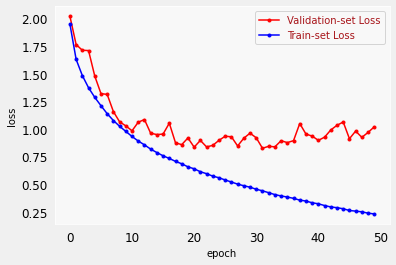

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 12s 75ms/step - loss: 1.0201 - accuracy: 0.7528
